#**TASK B: SEXISM CATEGORIZATION**

# **Library Imports**

In [14]:
import numpy as np
import pandas as pd
import re, string
import matplotlib.pyplot as plt
from tensorflow import keras
import tensorflow as tf
import nltk

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from mlxtend.plotting import plot_confusion_matrix
import matplotlib.ticker as ticker
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize, sent_tokenize
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score

from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras import layers
from sklearn.utils import class_weight
from imblearn.over_sampling import SMOTE

## **Loading Dataset**

In [15]:
df = pd.read_csv ('train_all_tasks.csv')
df.head (5)

,rewire_id,text,label_sexist,label_category,label_vector
0,sexism2022_english-7358,"Damn, this writing was pretty chaotic",not sexist,none,none
1,sexism2022_english-2367,"Yeah, and apparently a bunch of misogynistic v...",not sexist,none,none
2,sexism2022_english-3073,How the FUCK is this woman still an MP!!!???,not sexist,none,none
3,sexism2022_english-14895,Understand. Know you're right. At same time I ...,not sexist,none,none
4,sexism2022_english-4118,Surprized they didn't stop and rape some women,not sexist,none,none


# **Exploratory Data Analysis**

In [16]:
#Exploraing the data
print( 'The shape of the dataset: ', df.shape )

print( '\nDataset description:\n {}'.format( df.describe () ) )

print(".......................................................................")

print( 'Category unique values count:\r\n {}\n'.format( df ['label_category'].value_counts() ) )

print( df.isnull().sum() )
print('\nno of rows with null values in text column: ', df['text'].isnull().sum())
print('no of rows with null values in label_category column: ', df['label_category'].isnull().sum())

print("\n.......................................................................\n")

duplicate = df.duplicated('text')
print("How many duplicate texts are there: \n", duplicate.value_counts())    #No duplicate texts


The shape of the dataset:  (14000, 5)

Dataset description:
                       rewire_id                                   text  \
count                     14000                                  14000   
unique                    14000                                  14000   
top     sexism2022_english-7358  Damn, this writing was pretty chaotic   
freq                          1                                      1   

       label_sexist label_category label_vector  
count         14000          14000        14000  
unique            2              5           12  
top      not sexist           none         none  
freq          10602          10602        10602  
.......................................................................
Category unique values count:
 label_category
none                                        10602
2. derogation                                1590
3. animosity                                 1165
4. prejudiced discussions                     333


## **Pie Chart to view data distribution**

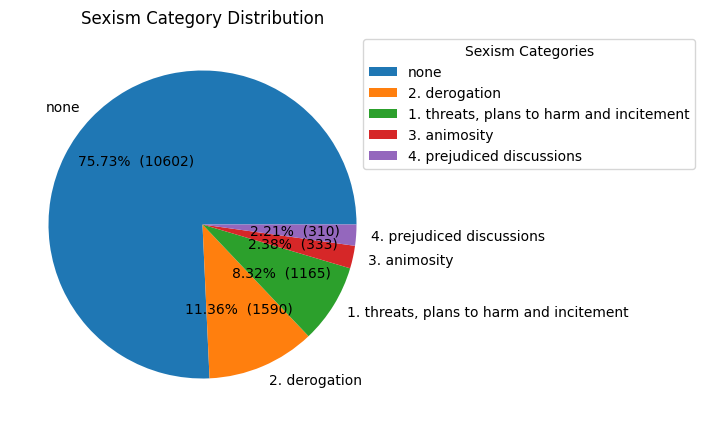

In [17]:
#Pie chart to plot how sexist and non-sexist texts are distributed
fig = plt.figure(figsize =(5, 5))

plt.title("Sexism Category Distribution")

plt.pie ( df['label_category'].value_counts(), labels = df['label_category'].unique().tolist(),
         autopct = lambda p : '{:.2f}%  ({:.0f})'.format( p, p * sum(df ['label_category'].value_counts()) / 100 ) )

plt.legend (title ="Sexism Categories", loc ="upper left", bbox_to_anchor =(0.9, 0, 0.5, 1))

plt.show()

## **Data Cleaning & Dropping column**

In [18]:
# removing special chars
def clean_text():
    clean = re.compile('<.*?>')

    df['text'] = df['text'].apply(lambda x: x.lower())
    df['text'] = df['text'].apply((lambda x: re.sub(clean, ' ', x)))
    df['text'] = df['text'].apply((lambda x: re.sub('https://.*', ' ', x)))
    # df['text'] = df['text'].apply((lambda x: re.sub('\.+', ' ', x)))         #not removing punctuations as model performs better without removal
    # df['text'] = df['text'].apply((lambda x: re.sub('[^a-zA-z0-9\s]', '', x)))

clean_text()


# Drops unnecessary or null columns
def drop_column(columns):
    global df
    df = df.drop(columns, axis = 1)

# Drops null rows
def drop_rows(columns):
    global df
    df = df.dropna(axis = 0, subset = columns)


drop = ['rewire_id']
drop_column(drop)

print( '\nThe shape of this dataset is now: {}\n'.format( df.shape ) )
df.tail()


The shape of this dataset is now: (14000, 4)



,text,label_sexist,label_category,label_vector
13995,complexes like the 'nice chicks' that go after...,sexist,2. derogation,2.1 descriptive attacks
13996,"""graphic germany - muslim ""refugee"" stabbing h...",not sexist,none,none
13997,lol i imagine there would be simps that are li...,not sexist,none,none
13998,"it's not, the girls i go on dates with don't k...",not sexist,none,none
13999,how can he be an incel? he does have a girlfri...,not sexist,none,none


# **Data Preprocessing**

## **Data Labeling**

In [19]:
# for sexism labeling as binary or categorical values
label_categorical = {
    'none': 0,
    '1. threats, plans to harm and incitement': 1,
    '2. derogation': 2,
    '3. animosity': 3,
    '4. prejudiced discussions': 4,
    }

df ['category_sexism'] = df ['label_category'].apply( lambda x : label_categorical [x] )

df.tail()

,text,label_sexist,label_category,label_vector,category_sexism
13995,complexes like the 'nice chicks' that go after...,sexist,2. derogation,2.1 descriptive attacks,2
13996,"""graphic germany - muslim ""refugee"" stabbing h...",not sexist,none,none,0
13997,lol i imagine there would be simps that are li...,not sexist,none,none,0
13998,"it's not, the girls i go on dates with don't k...",not sexist,none,none,0
13999,how can he be an incel? he does have a girlfri...,not sexist,none,none,0


# **Train-Validation-Test split**

In [20]:
#Train-valdation-test split
x = df['text']
y = df['category_sexism']

x_train, x_hold, y_train, y_hold = train_test_split (x, y, random_state = 42, test_size = 0.20, shuffle=True, stratify=y)
x_test, x_val, y_test, y_val = train_test_split (x_hold, y_hold, test_size = 0.50, random_state = 42, shuffle= True, stratify = y_hold)

# print('..........', len(y) )

print ( "Training Data size: x_train {}  y_train {}".format( x_train.shape, y_train.shape ), ' - {}%'.format( ( len(x_train) / len(y) ) * 100 ) )
print ( "Validation Data size: x_val {}, y_val {}".format( x_val.shape, y_val.shape ), ' - {}%'.format( ( len(x_val) / len(y) ) * 100 ) )
print ( "Testing Data size: x_test {}  y_test {}".format( x_test.shape, y_test.shape ), ' - {}%\n'.format( ( len(x_test) / len(y) ) * 100 ) )

print( 'y_train unique values counts:\n{}\n'.format( y_train.value_counts() ) )
print( 'y_val unique values counts:\n{}\n'.format( y_val.value_counts() ) )
print( 'y_test unique values counts:\n{}\n'.format( y_test.value_counts() ) )

print( x_train[3] )
print( y_train[3] )

Training Data size: x_train (11200,)  y_train (11200,)  - 80.0%
Validation Data size: x_val (1400,), y_val (1400,)  - 10.0%
Testing Data size: x_test (1400,)  y_test (1400,)  - 10.0%

y_train unique values counts:
category_sexism
0    8482
2    1272
3     932
4     266
1     248
Name: count, dtype: int64

y_val unique values counts:
category_sexism
0    1060
2     159
3     117
4      33
1      31
Name: count, dtype: int64

y_test unique values counts:
category_sexism
0    1060
2     159
3     116
4      34
1      31
Name: count, dtype: int64

understand. know you're right. at same time i know there isn't enough money in the world to induce me to do an beastly female equivalent.
0


# **Text Tokenization**

In [21]:
#Tokenization
num_words = 3000

print( "\nX-train value index 3 (before tokenization): ", x_train[3] )

tokenizer = Tokenizer (num_words = num_words, lower = False)


def tokenization( x_train, x_val, x_test ):

  tokenizer.fit_on_texts (x_train)

  tokenized_xtrain = tokenizer.texts_to_sequences (x_train)
  tokenized_xval = tokenizer.texts_to_sequences (x_val)
  tokenized_xtest = tokenizer.texts_to_sequences (x_test)

  return tokenized_xtrain, tokenized_xval, tokenized_xtest

x_train, x_val, x_test = tokenization (x_train, x_val, x_test)


vocab = tokenizer.word_index
vocab_size = len( tokenizer.word_index ) + 1


print( "\n", vocab )
print( "\nThe size of Vocabulary: ", vocab_size )

# print( "\nX-train value: {}\n".format( x_train ) )
print( "\nX-train value index 3 (after tokenization): ", x_train[3] )
print( "Y-train value index 3: ", y_train[3] )



X-train value index 3 (before tokenization):  understand. know you're right. at same time i know there isn't enough money in the world to induce me to do an beastly female equivalent.

 {'the': 1, 'a': 2, 'to': 3, 'and': 4, 'i': 5, 'you': 6, 'of': 7, 'is': 8, 'her': 9, 'that': 10, 'in': 11, 'she': 12, 'women': 13, 'it': 14, 'for': 15, 'are': 16, 'with': 17, 'this': 18, 'be': 19, 'on': 20, 'they': 21, 'not': 22, 'have': 23, 'if': 24, 'url': 25, 'but': 26, 'just': 27, 'like': 28, 'as': 29, 'your': 30, 'was': 31, 'my': 32, 'all': 33, 'so': 34, 'or': 35, 'what': 36, 'do': 37, 'woman': 38, 'me': 39, 'who': 40, 'get': 41, 'he': 42, 'about': 43, 'out': 44, 'no': 45, 'at': 46, 'up': 47, 'men': 48, "don't": 49, 'can': 50, 'will': 51, 'their': 52, 'would': 53, 'them': 54, 'user': 55, 'how': 56, 'an': 57, "it's": 58, 'by': 59, 'we': 60, 'when': 61, 'because': 62, 'one': 63, 'has': 64, 'girl': 65, 'from': 66, 'girls': 67, 'his': 68, 'fuck': 69, 'more': 70, 'want': 71, 'white': 72, 'female': 73, '

## **Padding tokenized texts**

In [22]:
#Padding the tokenized reviews
def padding (x_train, x_val, x_test):
    maxlen = 50

    padded_xtrain = pad_sequences( x_train, padding = 'post', maxlen = maxlen )
    padded_xval = pad_sequences( x_val, padding = 'post', maxlen = maxlen )
    padded_xtest = pad_sequences( x_test, padding = 'post', maxlen = maxlen )

    return maxlen, padded_xtrain, padded_xval, padded_xtest

maxlen, x_train, x_val, x_test = padding( x_train, x_val, x_test )


print("max length of each padded texts: ", maxlen)

print( "\n[ x_train.shape[0], x_train.shape[1] ]: [ {}, {} ]".format ( x_train.shape[0], x_train.shape[1] ) )
print( "\n[ x_val.shape[0], x_val.shape[1] ]: [ {}, {} ]".format ( x_val.shape[0], x_val.shape[1] ) )
print( "\n[ x_test.shape[0], x_test.shape[1] ]: [ {}, {} ]\n".format ( x_test.shape[0], x_test.shape[1] ) )

print( "X-train row index 3:\n", x_train[3, :] )


max length of each padded texts:  50

[ x_train.shape[0], x_train.shape[1] ]: [ 11200, 50 ]

[ x_val.shape[0], x_val.shape[1] ]: [ 1400, 50 ]

[ x_test.shape[0], x_test.shape[1] ]: [ 1400, 50 ]

X-train row index 3:
 [ 573 1957   27    2   13   17    2  294  460    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0]


In [23]:
from tensorflow.keras.utils import to_categorical

# Categorization of Y
num_classes = 5

y_train = to_categorical(y_train - 1, num_classes)
y_val = to_categorical(y_val - 1, num_classes)
y_test = to_categorical(y_test - 1, num_classes)

print("\ny_train shape:", y_train.shape)
print("y_train index 0:", y_train[0])

print('\n( shape of x_train, shape of y_train ): ( {}, {} )'.format(x_train.shape, y_train.shape))
print('( shape of x_val, shape of y_val ): ( {}, {} )'.format(x_val.shape, y_val.shape))
print('( shape of x_test, shape of y_test ): ( {}, {} )\n'.format(x_test.shape, y_test.shape))


y_train shape: (11200, 5)
y_train index 0: [0. 1. 0. 0. 0.]

( shape of x_train, shape of y_train ): ( (11200, 50), (11200, 5) )
( shape of x_val, shape of y_val ): ( (1400, 50), (1400, 5) )
( shape of x_test, shape of y_test ): ( (1400, 50), (1400, 5) )



## **Embedding matrix creation by GloVe embedding**

In [24]:
#func to create embedding_matrix through GloVe embedding
def create_embedding_matrix(filepath, word_index, embedding_dim):

    vocab_size = len(word_index) + 1  # Adding again 1 because of reserved 0 index
    embedding_matrix = np.zeros((vocab_size, embedding_dim))

    with open(filepath, encoding="utf8") as f:
        for line in f:
            word, *vector = line.split()
            if word in word_index:
                idx = word_index[word]
                embedding_matrix[idx] = np.array(
                    vector, dtype=np.float32)[:embedding_dim]

    return embedding_matrix


embedding_dim = 100
embedding_matrix = create_embedding_matrix( 'glove.6B.100d.txt', tokenizer.word_index, embedding_dim )

print("The embedding matrix with GLoVe embedding: \n", embedding_matrix)


#Non zero embedding vectors

nonzero_elements = np.count_nonzero( np.count_nonzero(embedding_matrix, axis=1) )
print( "Amount of nonzero embedding vectors: ", nonzero_elements / vocab_size )

The embedding matrix with GLoVe embedding: 
 [[ 0.          0.          0.         ...  0.          0.
   0.        ]
 [-0.038194   -0.24487001  0.72812003 ... -0.1459      0.82779998
   0.27061999]
 [-0.27085999  0.044006   -0.02026    ... -0.4923      0.63687003
   0.23642001]
 ...
 [ 0.17428    -0.40492001  0.54396999 ... -0.39197999  0.12698001
  -0.65447998]
 [ 0.045521   -0.28689     0.23307    ... -0.041397   -0.52139997
  -0.024642  ]
 [ 0.40079001 -0.57675999  0.06379    ...  0.33825001 -0.037264
  -0.050584  ]]
Amount of nonzero embedding vectors:  0.6565182671191855


# **Using LSTM**

## **Simple lstm structure**

In [25]:
#Simple LSTM structure to check performance
def lstm_simple (dense, maxlen):
    lstm_out = 128

    model = Sequential()
    model.add( layers.Embedding( vocab_size, embedding_dim, weights = [embedding_matrix], input_length = maxlen, trainable = True ) )
    model.add( layers.LSTM ( lstm_out, dropout = 0.2 ) )
    model.add( layers.Dense ( dense, activation ='softmax' ) )

    model.compile ( loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'] )
    print ( model.summary() )

    return model

model = lstm_simple (5, maxlen)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 50, 100)           2003600   
                                                                 
 lstm (LSTM)                 (None, 128)               117248    
                                                                 
 dense (Dense)               (None, 5)                 645       
                                                                 
Total params: 2121493 (8.09 MB)
Trainable params: 2121493 (8.09 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [26]:
#fitting model
batch_size = 32
history = model.fit( x_train, y_train, epochs = 20, verbose = True, validation_data = ( x_val, y_val ), batch_size = batch_size )

Epoch 1/20
350/350 [==============================] - 43s 114ms/step - loss: 0.8568 - accuracy: 0.7563 - val_loss: 0.8530 - val_accuracy: 0.7571
Epoch 2/20
350/350 [==============================] - 37s 105ms/step - loss: 0.8118 - accuracy: 0.7573 - val_loss: 0.7427 - val_accuracy: 0.7571
Epoch 3/20
350/350 [==============================] - 35s 101ms/step - loss: 0.6883 - accuracy: 0.7791 - val_loss: 0.6718 - val_accuracy: 0.7764
Epoch 4/20
350/350 [==============================] - 38s 110ms/step - loss: 0.6099 - accuracy: 0.7955 - val_loss: 0.6450 - val_accuracy: 0.7914
Epoch 5/20
350/350 [==============================] - 41s 116ms/step - loss: 0.5696 - accuracy: 0.7988 - val_loss: 0.6656 - val_accuracy: 0.7821
Epoch 6/20
350/350 [==============================] - 37s 106ms/step - loss: 0.5402 - accuracy: 0.8090 - val_loss: 0.6705 - val_accuracy: 0.7829
Epoch 7/20
350/350 [==============================] - 39s 112ms/step - loss: 0.5124 - accuracy: 0.8164 - val_loss: 0.6836 - val_ac

In [27]:
loss, accuracy = model.evaluate( x_train, y_train, verbose = False )
print( "\nTraining Accuracy: {:.4f}, Training Loss: {:.4f}".format(accuracy, loss) )

loss, accuracy = model.evaluate( x_test, y_test, verbose = False )
print( "Testing Accuracy:  {:.4f}, Testing Loss: {:.4f}\n".format(accuracy, loss) )

# print(history.history)


Training Accuracy: 0.9625, Training Loss: 0.1255
Testing Accuracy:  0.7529, Testing Loss: 1.0767



## **LSTM model Hyperparameter tuned**

In [28]:
def lstm_hypertuned (dense, maxlen):
    lstm_out = 128

    model = Sequential()

    model.add( layers.Embedding( vocab_size, embedding_dim, weights = [embedding_matrix], input_length = maxlen, trainable = True ) )
    model.add ( layers.SpatialDropout1D (0.4) )
    model.add( layers.LSTM ( lstm_out, dropout = 0.2, recurrent_dropout = 0.2, activation = 'tanh' ) )
    model.add( layers.Dense( 50, activation='relu' ) )
    model.add( layers.Dense ( dense, activation ='sigmoid' ) )

    model.compile ( loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'] )
    print ( model.summary() )

    return model

model2 = lstm_hypertuned (5, maxlen)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 50, 100)           2003600   
                                                                 
 spatial_dropout1d (Spatial  (None, 50, 100)           0         
 Dropout1D)                                                      
                                                                 
 lstm_1 (LSTM)               (None, 128)               117248    
                                                                 
 dense_1 (Dense)             (None, 50)                6450      
                                                                 
 dense_2 (Dense)             (None, 5)                 255       
                                                                 
Total params: 2127553 (8.12 MB)
Trainable params: 2127553 (8.12 MB)
Non-trainable params: 0 (0.00 Byte)
________________

In [29]:
#fitting model
batch_size = 64
history2 = model2.fit( x_train, y_train, epochs = 20, verbose = True, validation_data = ( x_val, y_val ), batch_size = batch_size )

Epoch 1/20
175/175 [==============================] - 37s 191ms/step - loss: 0.8738 - accuracy: 0.7528 - val_loss: 0.8450 - val_accuracy: 0.7571
Epoch 2/20
175/175 [==============================] - 33s 191ms/step - loss: 0.8401 - accuracy: 0.7573 - val_loss: 0.8365 - val_accuracy: 0.7571
Epoch 3/20
175/175 [==============================] - 45s 260ms/step - loss: 0.8339 - accuracy: 0.7573 - val_loss: 0.8336 - val_accuracy: 0.7571
Epoch 4/20
175/175 [==============================] - 40s 228ms/step - loss: 0.7866 - accuracy: 0.7573 - val_loss: 0.7297 - val_accuracy: 0.7571
Epoch 5/20
175/175 [==============================] - 34s 192ms/step - loss: 0.7050 - accuracy: 0.7670 - val_loss: 0.6755 - val_accuracy: 0.7821
Epoch 6/20
175/175 [==============================] - 33s 190ms/step - loss: 0.6378 - accuracy: 0.7870 - val_loss: 0.6414 - val_accuracy: 0.7814
Epoch 7/20
175/175 [==============================] - 35s 199ms/step - loss: 0.6163 - accuracy: 0.7938 - val_loss: 0.6384 - val_ac

### **Training-Testing loss and accuracy**

In [30]:
loss, accuracy = model2.evaluate( x_train, y_train, verbose = False )
print( "\nTraining Accuracy: {:.4f}, Training Loss: {:.4f}".format(accuracy, loss) )

losstest, accuracytest = model2.evaluate( x_test, y_test, verbose = False )
print( "Testing Accuracy:  {:.4f}, Testing Loss: {:.4f}\n".format(accuracytest, losstest) )

#Storing the best results
bestcate_lstm_accloss = [loss, accuracy, losstest, accuracytest, history2]

# print(history2.history)


Training Accuracy: 0.8593, Training Loss: 0.3977
Testing Accuracy:  0.7879, Testing Loss: 0.6847



### **Plotting Training & Validation loss & accuracy in Graph**

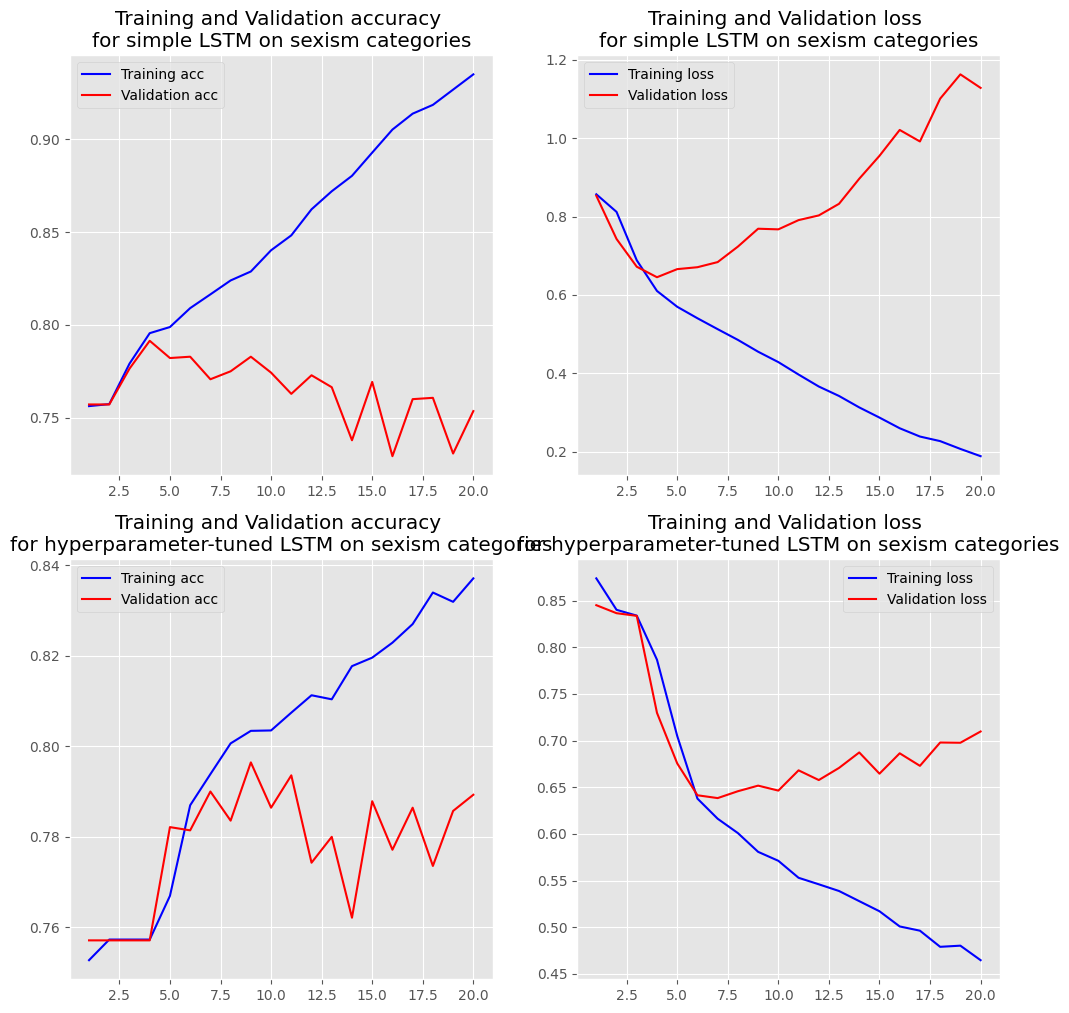

In [31]:
#graph for Training and Validation accuracy and loss comparision
plt.style.use('ggplot')

def plot_history(history1, history2, m, n):

    acc = history1.history['accuracy']
    val_acc = history1.history['val_accuracy']
    loss = history1.history['loss']
    val_loss = history1.history['val_loss']

    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 12))

    plt.subplot(2, 2, 1)
    plt.plot(x, acc, 'blue', label = 'Training acc')
    plt.plot(x, val_acc, 'red', label = 'Validation acc')
    plt.title('Training and Validation accuracy \nfor {}'.format(m))
    plt.legend()

    plt.subplot(2, 2, 2)
    plt.plot(x, loss, 'blue', label = 'Training loss')
    plt.plot(x, val_loss, 'red', label = 'Validation loss')
    plt.title('Training and Validation loss \nfor {}'.format(m))
    plt.legend()


    acc = history2.history['accuracy']
    val_acc = history2.history['val_accuracy']
    loss = history2.history['loss']
    val_loss = history2.history['val_loss']

    plt.subplot(2, 2, 3)
    plt.plot(x, acc, 'blue', label = 'Training acc')
    plt.plot(x, val_acc, 'red', label = 'Validation acc')
    plt.title('Training and Validation accuracy \nfor {}'.format(n))
    plt.legend()

    plt.subplot(2, 2, 4)
    plt.plot(x, loss, 'blue', label = 'Training loss')
    plt.plot(x, val_loss, 'red', label = 'Validation loss')
    plt.title('Training and Validation loss \nfor {}'.format(n))
    plt.legend()

plot_history(history, history2, "simple LSTM on sexism categories", "hyperparameter-tuned LSTM on sexism categories")

## **LSTM parameter-tuned Prediction**

In [32]:
# Accuracy score and classification report func
def accuracy_classificationrep( model, y_test, y_pred, show_pred ):

    if (show_pred):
        print('\n{} prediction for test data: {}\n'.format(model, y_pred))

    score = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, output_dict = True)

    target_names = ['0(none)', '1(threats/ harm)', '2(derogation)', '3(animosity)', '4(prejudiced discussion)']

    print("\n{} accuracy score : {}".format(model, score))
    print( "\n{} classification report :\n{}\n".format( model, classification_report(y_test, y_pred,
                                                                                     target_names = target_names ) ) )
    return report

In [33]:
#Prediction
prediction = model2.predict (x_test)
print ('\nprediction value: ', prediction)

y_pred = np.argmax (prediction, axis = 1)
print ('\ny PREDICTED sexism categories: ', y_pred)

y_test_ = np.argmax (y_test, axis = 1)
print ('y TESTED sexism categories: ', y_test_)

lstmcate_report = accuracy_classificationrep( "For sexism category LSTM Hyperparameter-tuned", y_test_, y_pred, False )

print( lstmcate_report )

44/44 [==============================] - 1s 18ms/step

prediction value:  [[0.12356552 0.10319824 0.13397321 0.03765199 0.9758499 ]
 [0.31875357 0.11300839 0.15414059 0.06932671 0.9471706 ]
 [0.16280608 0.08383225 0.11402468 0.02771595 0.9792344 ]
 ...
 [0.11199041 0.38434047 0.41624746 0.1584276  0.9067276 ]
 [0.48470676 0.8981532  0.8876594  0.17283572 0.12195064]
 [0.24146686 0.11698867 0.16566741 0.04592868 0.95859504]]

y PREDICTED sexism categories:  [4 4 4 ... 4 1 4]
y TESTED sexism categories:  [2 4 4 ... 4 1 4]

For sexism category LSTM Hyperparameter-tuned accuracy score : 0.7878571428571428

For sexism category LSTM Hyperparameter-tuned classification report :
                          precision    recall  f1-score   support

                 0(none)       0.00      0.00      0.00        31
        1(threats/ harm)       0.37      0.41      0.39       159
           2(derogation)       0.54      0.34      0.41       116
            3(animosity)       0.00      0.00      0.00

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

### **Confusion matrix and Heat-map**

In [34]:
# Confusion Matrix func
def confusionMatrix(s, y_test, predict):

    cm = confusion_matrix( y_test, predict)
    crosstab = pd.crosstab(y_test, predict, rownames = ['Actual'], colnames =['Predicted'], margins = True)
    print("\n{} confusion matrix :\n {}".format(s, crosstab))

    return cm


# Plot Heat-map func
def plot_heat_map(s, cm, cmap):

    class_names = ['0(none)', '1(threats/ harm)', '2(derogation)', '3(animosity)', '4(prejudiced discussion)']

    fig, ax = plot_confusion_matrix( conf_mat = cm, figsize = (6, 6), colorbar = True, show_absolute = True,
                                show_normed = True, cmap = cmap, class_names=class_names )

    plt.ylabel("Predicted sexism category for {}\n".format(s), fontsize = 10)
    plt.xlabel("True sexism category for {}".format(s), fontsize = 10)
    plt.title("\nHeat-map of confusion matrix Predicted sexism category \nversus True category for {}".format(s), fontsize = 10)

    plt.show()


LSTM hyperparameter-tuned confusion matrix :
 Predicted    1   2     4   All
Actual                        
0            6   0    25    31
1           65  30    64   159
2           39  39    38   116
3           10   0    24    34
4           58   3   999  1060
All        178  72  1150  1400


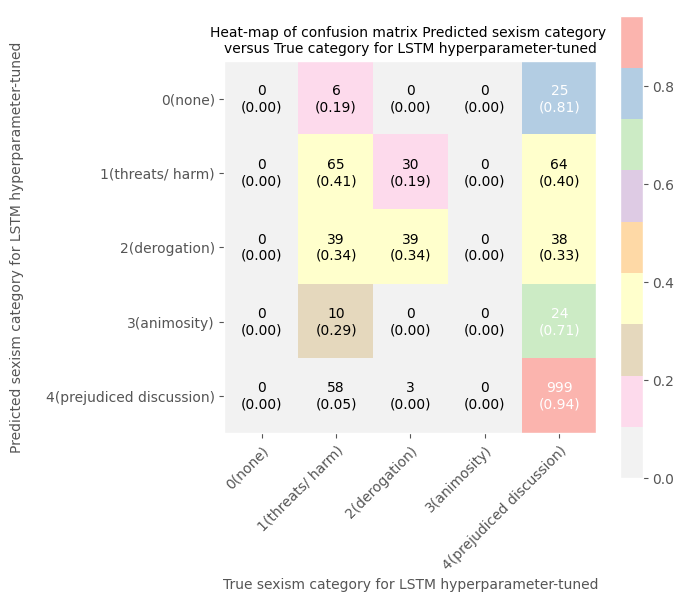

In [35]:
#Confusion matrix for LSTM
cm_lstm_hyper = confusionMatrix("LSTM hyperparameter-tuned", y_test_, y_pred)

#Heat-map for LSTM
plot_heat_map("LSTM hyperparameter-tuned", cm_lstm_hyper, plt.cm.Pastel1_r)

# **Imbalance in dataset checking**
Here we see an imbalance, the sexist class is much lesser in amount than the non sexist class and this imbalance needs to be handled to tackle overfitting problem. We will handle it in two ways - **class weight assignment** and **oversampling via synthetic data generation using SMOTE**

In [36]:
y_train_count = np.argmax (y_train, axis = 1)

y_train_count = pd.DataFrame( y_train_count )

print( y_train_count.value_counts() )


4    8482
1    1272
2     932
3     266
0     248
Name: count, dtype: int64


## **Class weight assignment**

In [37]:
from sklearn.utils import class_weight

unique_classes = list( df['category_sexism'].unique() )
print(unique_classes)

out_dict = {}
for classes in unique_classes:
    out_dict[classes] = df.shape[0] / ( ( df.loc[ df['category_sexism'] == classes ].shape[0] ) * len(unique_classes) )

# print( "\nThe class weights are: ", out_dict )

manual_weights = { 0: 5, 1: 100, 2: 25, 3: 50, 4: 70 }

print('The weights set manually are: ', manual_weights)

# y_integers = np.argmax(y_train, axis = 1)

# class_weights = class_weight.compute_class_weight( class_weight = "balanced", classes = np.unique( y_integers ),
#                                                   y = y_integers )

# class_weights = dict( enumerate( class_weights ) )

[0, 2, 1, 3, 4]
The weights set manually are:  {0: 5, 1: 100, 2: 25, 3: 50, 4: 70}


In [38]:
#fitting model
batch_size = 64

history = model2.fit( x_train, y_train, epochs = 20, class_weight = manual_weights,
                     verbose = True, validation_data = ( x_val, y_val ), batch_size = batch_size )

# history = model2.fit( x_train, y_train, epochs = 10, class_weight = class_weights,
#                      verbose = True, validation_data = ( x_val, y_val ), batch_size = batch_size )

Epoch 1/20
175/175 [==============================] - 38s 206ms/step - loss: 24.5787 - accuracy: 0.8151 - val_loss: 0.7682 - val_accuracy: 0.7657
Epoch 2/20
175/175 [==============================] - 35s 199ms/step - loss: 21.6456 - accuracy: 0.8285 - val_loss: 0.8083 - val_accuracy: 0.7707
Epoch 3/20
175/175 [==============================] - 35s 200ms/step - loss: 20.4289 - accuracy: 0.8358 - val_loss: 0.8279 - val_accuracy: 0.7650
Epoch 4/20
175/175 [==============================] - 35s 200ms/step - loss: 19.4961 - accuracy: 0.8396 - val_loss: 0.8220 - val_accuracy: 0.7593
Epoch 5/20
175/175 [==============================] - 40s 229ms/step - loss: 18.2862 - accuracy: 0.8497 - val_loss: 0.8292 - val_accuracy: 0.7714
Epoch 6/20
175/175 [==============================] - 35s 197ms/step - loss: 18.0175 - accuracy: 0.8514 - val_loss: 0.8521 - val_accuracy: 0.7721
Epoch 7/20
175/175 [==============================] - 35s 201ms/step - loss: 17.1453 - accuracy: 0.8551 - val_loss: 0.8821 -

In [39]:
loss, accuracy = model2.evaluate( x_train, y_train, verbose = False )
print( "\nAfter Class Weight Assignment - Training Accuracy: {:.4f}, Training Loss: {:.4f}".format(accuracy, loss) )

loss, accuracy = model2.evaluate( x_test, y_test, verbose = False )
print( "After Class Weight Assignment - Testing Accuracy:  {:.4f}, Testing Loss: {:.4f}\n".format(accuracy, loss) )

# print(history.history)


After Class Weight Assignment - Training Accuracy: 0.9109, Training Loss: 0.2944
After Class Weight Assignment - Testing Accuracy:  0.7714, Testing Loss: 1.0245



### **Prediction after class-weight assignmnet**

In [40]:
#Prediction after class weights
prediction = model2.predict (x_test)

y_pred = np.argmax (prediction, axis = 1)
y_test_ = np.argmax (y_test, axis = 1)

# df2 = pd.DataFrame (y_pred)
# print(df2.tail(20))

# df3 = pd.DataFrame (y_test_)
# print(df3.tail(20))


lstmcate_report_cw = accuracy_classificationrep( "For sexism category LSTM \nafter class-weight assignment",
                                                y_test_, y_pred, True )


44/44 [==============================] - 1s 20ms/step

For sexism category LSTM 
after class-weight assignment prediction for test data: [4 4 4 ... 4 1 4]


For sexism category LSTM 
after class-weight assignment accuracy score : 0.7714285714285715

For sexism category LSTM 
after class-weight assignment classification report :
                          precision    recall  f1-score   support

                 0(none)       0.00      0.00      0.00        31
        1(threats/ harm)       0.37      0.51      0.43       159
           2(derogation)       0.44      0.21      0.28       116
            3(animosity)       0.17      0.09      0.12        34
4(prejudiced discussion)       0.88      0.92      0.90      1060

                accuracy                           0.77      1400
               macro avg       0.37      0.34      0.34      1400
            weighted avg       0.75      0.77      0.75      1400




/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

### **Confusion matrix and Heatmap**


LSTM Class-Weight Assignment for sexism category confusion matrix :
 Predicted    1   2   3     4   All
Actual                            
0            6   0   0    25    31
1           81  22   5    51   159
2           52  24   1    39   116
3            8   0   3    23    34
4           70   9   9   972  1060
All        217  55  18  1110  1400


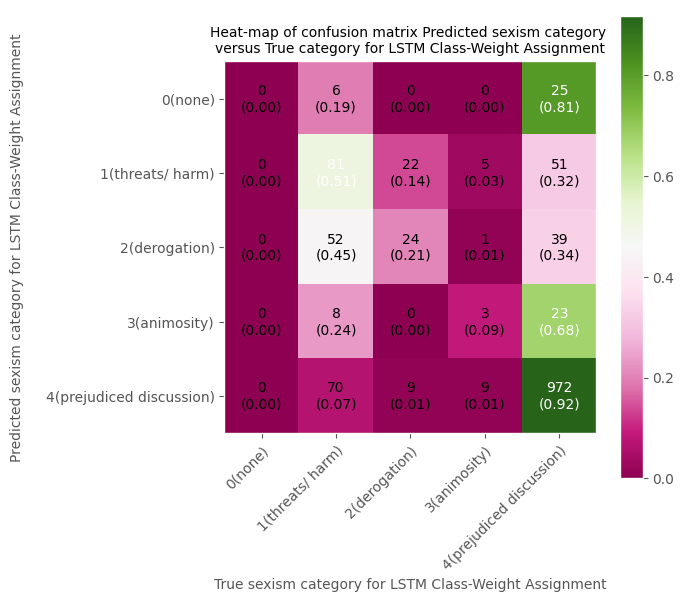

In [41]:
#Confusion matrix
cm_lstm_cw = confusionMatrix("LSTM Class-Weight Assignment for sexism category", y_test_, y_pred)

#Heat-map
plot_heat_map("LSTM Class-Weight Assignment", cm_lstm_cw, plt.cm.PiYG)

## **SMOTE**

In [42]:
from imblearn.over_sampling import SMOTE

smote = SMOTE()
xtrain_sm, ytrain_sm = smote.fit_resample( x_train, y_train )


y_train_count = np.argmax ( ytrain_sm, axis = 1 )

y_train_count = pd.DataFrame( y_train_count )


print("After resampling with SMOTE, unique counts in y_train:\n", y_train_count.value_counts())

print("\nx_train after resampling: \n", xtrain_sm)
print("\ny_train after resampling: \n", ytrain_sm)

After resampling with SMOTE, unique counts in y_train:
 0    8482
1    8482
2    8482
3    8482
4    8482
Name: count, dtype: int64

x_train after resampling: 
 [[865 695   7 ...   0   0   0]
 [207 123  17 ...   0   0   0]
 [ 77   2 191 ...   0   0   0]
 ...
 [ 13 116  68 ...   0   0   0]
 [ 99 309 512 ...   0   0   0]
 [ 77  27  29 ...   0   0   0]]

y_train after resampling: 
 [[0 1 0 0 0]
 [0 0 0 0 1]
 [0 0 0 0 1]
 ...
 [0 0 0 1 0]
 [0 0 0 1 0]
 [0 0 0 1 0]]


In [43]:
#fitting model
batch_size = 64
history2 = model2.fit( xtrain_sm, ytrain_sm, epochs = 20, verbose = True, validation_data = ( x_val, y_val ), batch_size = batch_size )

Epoch 1/20
663/663 [==============================] - 144s 214ms/step - loss: 1.7411 - accuracy: 0.3005 - val_loss: 1.4986 - val_accuracy: 0.5279
Epoch 2/20
663/663 [==============================] - 143s 216ms/step - loss: 1.5180 - accuracy: 0.3120 - val_loss: 1.4794 - val_accuracy: 0.5486
Epoch 3/20
663/663 [==============================] - 141s 213ms/step - loss: 1.5035 - accuracy: 0.3194 - val_loss: 1.5011 - val_accuracy: 0.4643
Epoch 4/20
663/663 [==============================] - 145s 219ms/step - loss: 1.4883 - accuracy: 0.3262 - val_loss: 1.5588 - val_accuracy: 0.4329
Epoch 5/20
663/663 [==============================] - 144s 217ms/step - loss: 1.4724 - accuracy: 0.3367 - val_loss: 1.4253 - val_accuracy: 0.5043
Epoch 6/20
663/663 [==============================] - 146s 220ms/step - loss: 1.4557 - accuracy: 0.3491 - val_loss: 1.4719 - val_accuracy: 0.4879
Epoch 7/20
663/663 [==============================] - 144s 217ms/step - loss: 1.4370 - accuracy: 0.3599 - val_loss: 1.3370 -

In [44]:
loss, accuracy = model2.evaluate( xtrain_sm, ytrain_sm, verbose = False )
print( "\nAfter SMOTE - Training Accuracy: {:.4f}, Training Loss: {:.4f}".format(accuracy, loss) )

losstest, accuracytest = model2.evaluate( x_test, y_test, verbose = False )
print( "After SMOTE - Testing Accuracy:  {:.4f}, Testing Loss: {:.4f}\n".format(accuracytest, losstest) )


#Storing the best results on imbalance-handled dataset
bestcate_lstmbalance_accloss = [loss, accuracy, losstest, accuracytest, history2]

# print(history2.history)


After SMOTE - Training Accuracy: 0.5050, Training Loss: 1.0635
After SMOTE - Testing Accuracy:  0.7279, Testing Loss: 0.9962



### **Prediction after SMOTE**

In [45]:
#Prediction after SMOTE
prediction = model2.predict (x_test)

y_pred = np.argmax (prediction, axis = 1)
y_test_ = np.argmax (y_test, axis = 1)

lstmcate_report_sm = accuracy_classificationrep( "For sexism category LSTM \nafter SMOTE", y_test_, y_pred, False )


44/44 [==============================] - 1s 19ms/step

For sexism category LSTM 
after SMOTE accuracy score : 0.7278571428571429

For sexism category LSTM 
after SMOTE classification report :
                          precision    recall  f1-score   support

                 0(none)       0.03      0.03      0.03        31
        1(threats/ harm)       0.35      0.32      0.34       159
           2(derogation)       0.34      0.38      0.36       116
            3(animosity)       0.17      0.21      0.19        34
4(prejudiced discussion)       0.87      0.86      0.87      1060

                accuracy                           0.73      1400
               macro avg       0.35      0.36      0.36      1400
            weighted avg       0.74      0.73      0.73      1400




### **Confusion matrix and Heatmap**


LSTM SMOTE for sexism category confusion matrix :
 Predicted   0    1    2   3     4   All
Actual                                 
0           1    5    1   0    24    31
1           3   51   49   5    51   159
2           2   30   44   1    39   116
3           0    4    6   7    17    34
4          33   55   28  28   916  1060
All        39  145  128  41  1047  1400


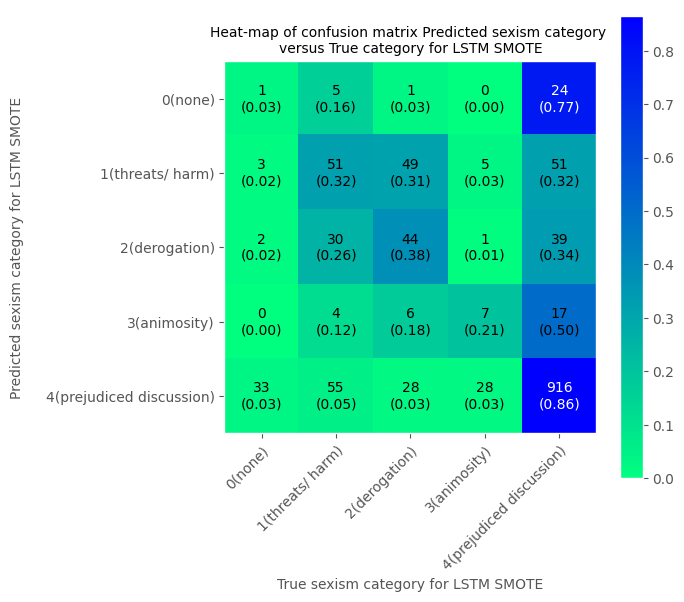

In [46]:
#Confusion matrix
cm_lstm_smote = confusionMatrix("LSTM SMOTE for sexism category", y_test_, y_pred)

#Heat-map
plot_heat_map("LSTM SMOTE", cm_lstm_smote, plt.cm.winter_r)

## **Training & Validation loss & accuracy Graph comparing Class-weight & SMOTE**

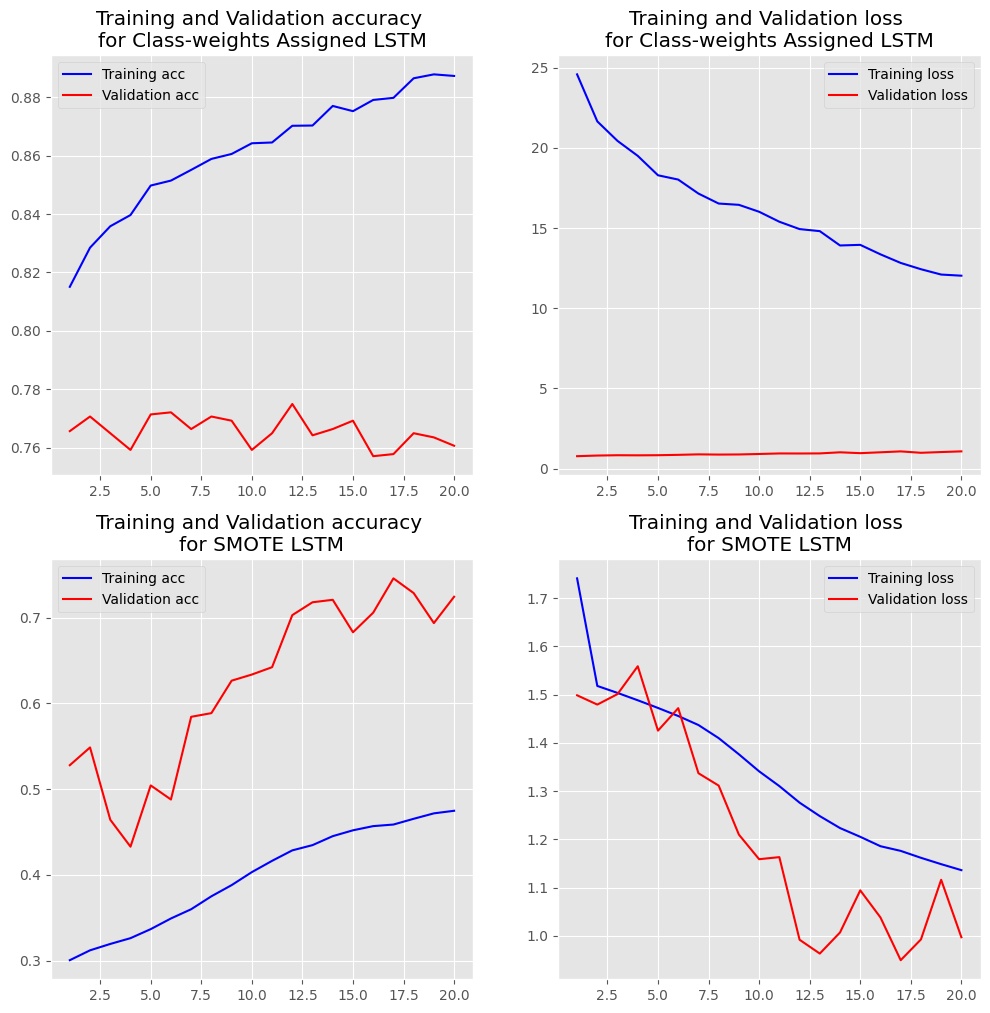

In [47]:
plot_history(history, history2, "Class-weights Assigned LSTM", "SMOTE LSTM")

## **Bargraphs Comparing**

In [48]:
model_names = ['Lstm-Parameter-tuned', 'Lstm-Class-weights', 'Lstm-SMOTE']

colors = ['rosybrown', 'lightsteelblue', 'indianred', 'lightseagreen', 'salmon', 'cornflowerblue']

nonsexist_scores = {
                    'f1-score': [lstmcate_report['0']['f1-score'], lstmcate_report_cw['0']['f1-score'], lstmcate_report_sm['0']['f1-score']],
                    'precision': [lstmcate_report['0']['precision'], lstmcate_report_cw['0']['precision'], lstmcate_report_sm['0']['precision']],
                    'recall': [lstmcate_report['0']['recall'], lstmcate_report_cw['0']['recall'], lstmcate_report_sm['0']['recall']]
                    }
threat_scores = {
                    'f1-score': [lstmcate_report['1']['f1-score'], lstmcate_report_cw['1']['f1-score'], lstmcate_report_sm['1']['f1-score']],
                    'precision': [lstmcate_report['1']['precision'], lstmcate_report_cw['1']['precision'], lstmcate_report_sm['1']['precision']],
                    'recall': [lstmcate_report['1']['recall'], lstmcate_report_cw['1']['recall'], lstmcate_report_sm['1']['recall']]
                    }
dero_scores = {
                    'f1-score': [lstmcate_report['2']['f1-score'], lstmcate_report_cw['2']['f1-score'], lstmcate_report_sm['2']['f1-score']],
                    'precision': [lstmcate_report['2']['precision'], lstmcate_report_cw['2']['precision'], lstmcate_report_sm['2']['precision']],
                    'recall': [lstmcate_report['2']['recall'], lstmcate_report_cw['2']['recall'], lstmcate_report_sm['2']['recall']]
                    }
animo_scores = {
                    'f1-score': [lstmcate_report['3']['f1-score'], lstmcate_report_cw['3']['f1-score'], lstmcate_report_sm['3']['f1-score']],
                    'precision': [lstmcate_report['3']['precision'], lstmcate_report_cw['3']['precision'], lstmcate_report_sm['3']['precision']],
                    'recall': [lstmcate_report['3']['recall'], lstmcate_report_cw['3']['recall'], lstmcate_report_sm['3']['recall']]
                    }
prejudice_scores = {
                    'f1-score': [lstmcate_report['4']['f1-score'], lstmcate_report_cw['4']['f1-score'], lstmcate_report_sm['4']['f1-score']],
                    'precision': [lstmcate_report['4']['precision'], lstmcate_report_cw['4']['precision'], lstmcate_report_sm['4']['precision']],
                    'recall': [lstmcate_report['4']['recall'], lstmcate_report_cw['4']['recall'], lstmcate_report_sm['4']['recall']]
                    }

### **Bar Graph precision, recall & f1-score**

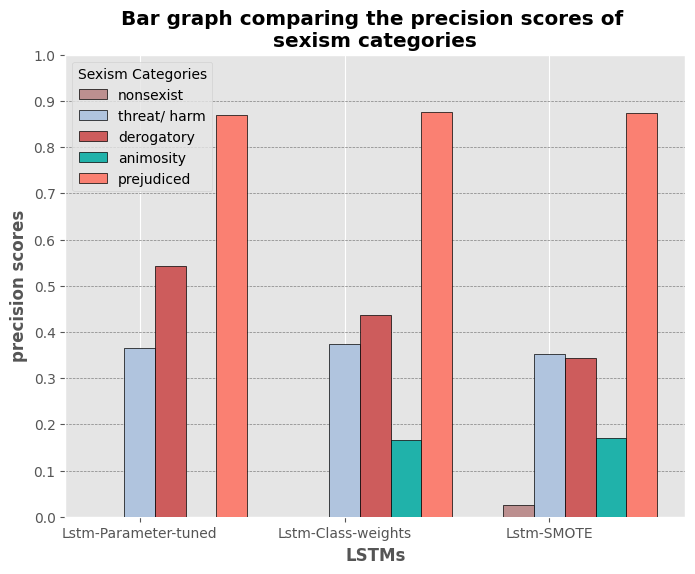

In [49]:
def plot_bar(model_names, nonsexist_scores, threat_scores, dero_scores, animo_scores, prejudice_scores, colors, metric):

    barWidth = 0.15
    colors = colors

    # Set position of bar on X axis
    br1 = np.arange(len(model_names))
    br2 = [x + barWidth for x in br1]
    br3 = [x + barWidth for x in br2]
    br4 = [x + barWidth for x in br3]
    br5 = [x + barWidth for x in br4]

    fig = plt.figure(figsize =(8, 6))

    plt.ylim(0.0, 1.0)
    plt.bar(br1, nonsexist_scores, color =colors[0], edgecolor ='black', width = barWidth, label ='nonsexist', zorder = 3)
    plt.bar(br2, threat_scores, color =colors[1], edgecolor ='black', width = barWidth, label ='threat/ harm', zorder = 3)
    plt.bar(br3, dero_scores, color =colors[2], edgecolor ='black', width = barWidth, label ='derogatory', zorder = 3)
    plt.bar(br4, animo_scores, color =colors[3], edgecolor ='black', width = barWidth, label ='animosity', zorder = 3)
    plt.bar(br5, prejudice_scores, color =colors[4], edgecolor ='black', width = barWidth, label ='prejudiced', zorder = 3)

    # Adding labels and ticks
    plt.xlabel("LSTMs", fontweight ='bold')
    plt.ylabel(metric, fontweight ='bold')
    plt.title("Bar graph comparing the {} of \nsexism categories".format(metric), fontweight ='bold')

    plt.xticks( [ r + barWidth for r in range( len(model_names) ) ], model_names )
    plt.yticks( np.arange( 0.0, 1.1, 0.1 ) )

    plt.legend(title='Sexism Categories')
    plt.grid(color = 'grey', linestyle = '--', linewidth = 0.5, zorder = 0, axis = 'y')

    plt.show()

plot_bar( model_names, nonsexist_scores["precision"], threat_scores["precision"], dero_scores["precision"],
         animo_scores["precision"], prejudice_scores["precision"], colors, 'precision scores' )

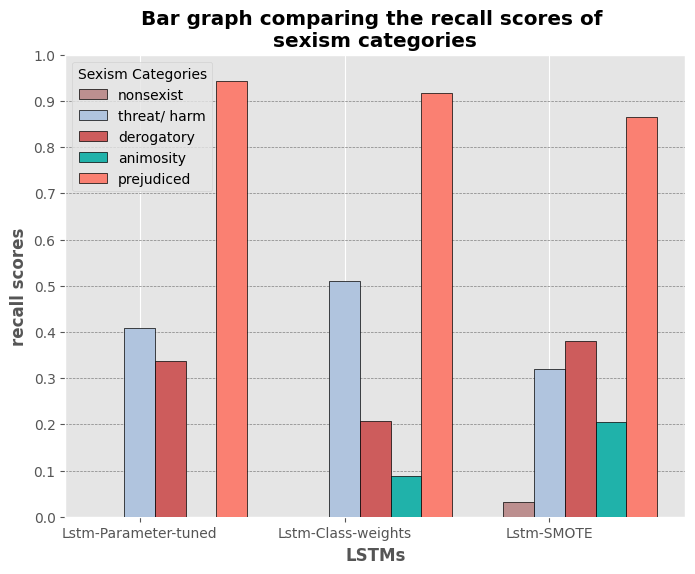

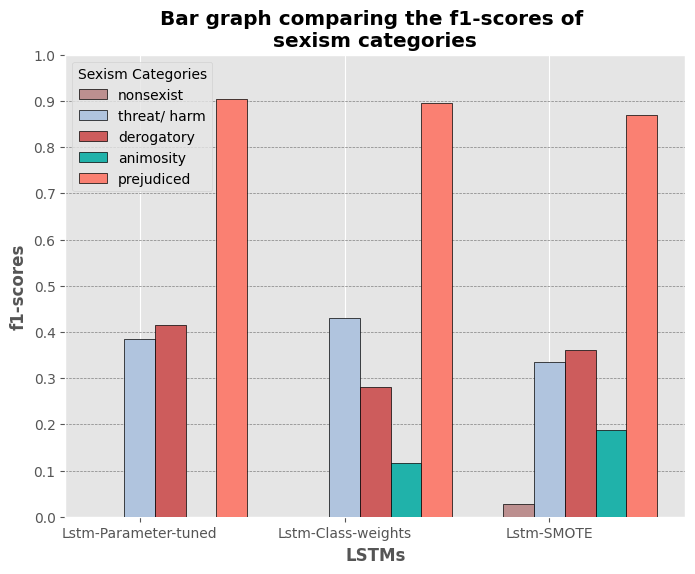

In [50]:
plot_bar( model_names, nonsexist_scores["recall"], threat_scores["recall"], dero_scores["recall"],
         animo_scores["recall"], prejudice_scores["recall"], colors, 'recall scores' )

plot_bar( model_names, nonsexist_scores["f1-score"], threat_scores["f1-score"], dero_scores["f1-score"],
         animo_scores["f1-score"], prejudice_scores["f1-score"], colors, 'f1-scores' )

### **Bargraph showing 4 performance metrics**

[0.3551061716332845, 0.33749295163738885, 0.3409445383538371, 0.7878571428571428]
[0.3703955736213801, 0.3443093880362815, 0.34455799363251594, 0.7714285714285715]
[0.35334549643188584, 0.36047128453245003, 0.35618056510482676, 0.7278571428571429]


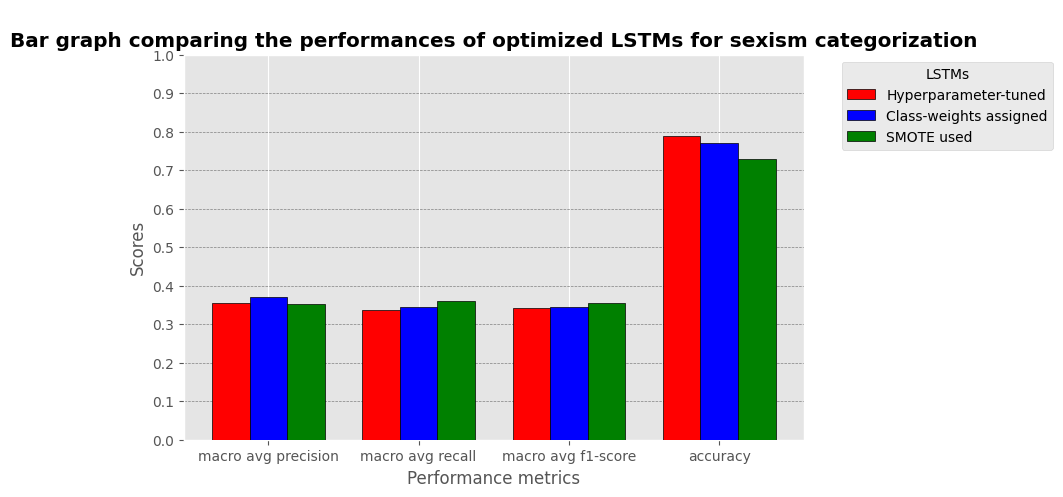

In [51]:
#Bargraph showing 4 performance metrics for these models
barWidth = 0.25
fig = plt.subplots(figsize =(8, 5))

metrics = ['macro avg precision', 'macro avg recall', 'macro avg f1-score', 'accuracy']

lstmcate = [lstmcate_report['macro avg']['precision'], lstmcate_report['macro avg']['recall'],
        lstmcate_report['macro avg']['f1-score'], lstmcate_report['accuracy']]

lstmcate_cw = [lstmcate_report_cw['macro avg']['precision'], lstmcate_report_cw['macro avg']['recall'],
        lstmcate_report_cw['macro avg']['f1-score'], lstmcate_report_cw['accuracy']]

lstmcate_sm = [lstmcate_report_sm['macro avg']['precision'], lstmcate_report_sm['macro avg']['recall'],
        lstmcate_report_sm['macro avg']['f1-score'], lstmcate_report_sm['accuracy']]

print(lstmcate)
print(lstmcate_cw)
print(lstmcate_sm)

# Set position of bar on X axis
br1 = np.arange(len(metrics))
br2 = [x + barWidth for x in br1]
br3 = [x + barWidth for x in br2]

# Make the plot
plt.ylim(0.0, 1.0)
plt.bar(br1, lstmcate, color = 'red', edgecolor = 'black', width = barWidth, label = 'Hyperparameter-tuned', zorder = 3)
plt.bar(br2, lstmcate_cw, color = 'blue', edgecolor = 'black', width = barWidth, label = 'Class-weights assigned', zorder = 3)
plt.bar(br3, lstmcate_sm, color = 'green', edgecolor = 'black', width = barWidth, label = 'SMOTE used', zorder = 3)

# Adding labels and ticks
plt.xlabel("Performance metrics")
plt.ylabel("Scores")
plt.title("\nBar graph comparing the performances of optimized LSTMs for sexism categorization", fontweight ='bold')

plt.xticks( [ r + barWidth for r in range( len(metrics) ) ], metrics )
plt.yticks( np.arange( 0.0, 1.1, 0.1 ) )

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title='LSTMs')
plt.grid(color = 'grey', linestyle = '--', linewidth = 0.5, zorder = 0, axis = 'y')
plt.show()

In [52]:
#best among imbalanced data
bestcate_performance = { 'lossacchis': bestcate_lstm_accloss, 'classification_report': lstmcate_report }
#best among imbalance-handled data
bestcate_performance_balance = { 'lossacchis': bestcate_lstmbalance_accloss, 'classification_report': lstmcate_report_sm }

print('============================================\n', bestcate_performance['lossacchis'], '\n')
print('============================================\n', bestcate_performance['classification_report'], '\n')

print('============================================\n', bestcate_performance_balance['lossacchis'], '\n')
print('============================================\n', bestcate_performance_balance['classification_report'])

 [0.39774179458618164, 0.8592857122421265, 0.6847116947174072, 0.7878571152687073, <keras.src.callbacks.History object at 0x7da4155c2fb0>] 

 {'0': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 31}, '1': {'precision': 0.3651685393258427, 'recall': 0.4088050314465409, 'f1-score': 0.3857566765578635, 'support': 159}, '2': {'precision': 0.5416666666666666, 'recall': 0.33620689655172414, 'f1-score': 0.41489361702127664, 'support': 116}, '3': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 34}, '4': {'precision': 0.8686956521739131, 'recall': 0.9424528301886792, 'f1-score': 0.9040723981900453, 'support': 1060}, 'accuracy': 0.7878571428571428, 'macro avg': {'precision': 0.3551061716332845, 'recall': 0.33749295163738885, 'f1-score': 0.3409445383538371, 'support': 1400}, 'weighted avg': {'precision': 0.7440803731360645, 'recall': 0.7878571428571428, 'f1-score': 0.7626997951632974, 'support': 1400}} 

 [1.0634589195251465, 0.5049752593040466, 0.9962429404258728, 0.